# PureGym – Customer Review Topic & Emotion Analysis (Google + Trustpilot)

## Business problem
PureGym receives a high volume of customer reviews across platforms. Manually reading reviews does not scale, and it makes it difficult to identify recurring operational issues by location.

## Objective
Build a repeatable NLP pipeline that:
- Cleans and standardises review text across sources
- Surfaces recurring issues via topic modelling (BERTopic; benchmark with LDA)
- Adds an emotion signal to better prioritise high-frustration feedback
- Produces location-level insights to support operational prioritisation

## Data
Two sources of English-language reviews:
- Google reviews (rating, location, comment text)
- Trustpilot reviews (stars, location, review content)

## Scope and assumptions
- Ratings < 3 are treated as negative reviews for both sources.
- Location names are used as the join key; minor naming inconsistencies may reduce matches.
- Topic models provide directional insights and require human validation before action.


In [ ]:
!pip install -U -q plotly==5.19.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 87.4 MB/s eta 0:00:00


# 1.Importing packages and data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords',quiet = True)
nltk.download('punkt',quiet = True)
nltk.download('punkt_tab',quiet = True)
nltk.download('wordnet',quiet = True)

from nltk import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer


import seaborn as sns
import re

In [ ]:
"""
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

"""

def word_cloud_display(df, column_name, title_common_words, title_wordcloud, n=10):
    # 1. Define stopwords inside function
    custom_stopwords = {
        "gym","friendly","always","really","one","get","use","good",
        "like","would","well","people","also","pure","even","puregym",
        "could","nice","need","day","month","year","week","today","yesterday"
    }
    stop_words = set(stopwords.words("english")) | custom_stopwords
    lemmatizer = WordNetLemmatizer()

    # 2. Clean text
    def clean_review(text):
        if pd.isnull(text):
            return ""
        text = str(text).lower()
        text = re.sub(r'[^a-z\s]', ' ', text)   # keep only letters
        words = word_tokenize(text)
        words = [w for w in words if w not in stop_words and len(w) > 2]
        words = [lemmatizer.lemmatize(w) for w in words]
        return " ".join(words)

    df["processed_comments"] = df[column_name].apply(clean_review)

    # 3. Tokenize all text
    all_words = " ".join(df["processed_comments"])
    tokens = all_words.split()

    # 4. Frequency distribution
    freq_dist = nltk.FreqDist(tokens)
    freq_df = pd.DataFrame(freq_dist.most_common(n), columns=["Word", "Frequency"])
    #print("Total Count:", len(freq_df))
    print("Top 10 Words:\n",freq_df.head(10))


    # 5. Side-by-side plots
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Left: Bar chart
    sns.barplot(ax=axes[0], x="Word", y="Frequency", data=freq_df, palette="viridis")
    axes[0].set_title(title_common_words)
    axes[0].set_xlabel("Word")
    axes[0].set_ylabel("Frequency")
    axes[0].tick_params(axis='x', rotation=45)

    # Right: Word cloud
    wordcloud = WordCloud(
        width=600, height=400,
        background_color="white",
        stopwords=stop_words
    ).generate(all_words)

    axes[1].imshow(wordcloud, interpolation="bilinear")
    axes[1].axis("off")
    axes[1].set_title(title_wordcloud)

    plt.tight_layout()
    plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1.1 Import data from Google Drive

In [ ]:
import os
# Check if the files exist before downloading
if not os.path.exists('Google_12_months.xlsx'):
    print("Downloading Google dataset...")
    !gdown --fuzzy 'https://docs.google.com/spreadsheets/d/13TeZTT6oqk3iPELBhFx9hComIfChKw4m/edit?usp=sharing'
else:
    print("Google dataset already exists.")

if not os.path.exists('Trustpilot_12_months.xlsx'):
    print("Downloading Trustpilot dataset...")
    !gdown --fuzzy 'https://docs.google.com/spreadsheets/d/1V6Pr6xWrHSHaothB61MJbR7mPFHwQ1u6/edit?usp=sharing'
else:
    print("Trustpilot dataset already exists.")

# Load the datasets into pandas DataFrames
google_df = pd.read_excel('Google_12_months.xlsx')
trustpilot_df = pd.read_excel('Trustpilot_12_months.xlsx')

# Display the first few rows of each dataset
print("Google Reviews Dataset:")
print(google_df.head())

Downloading...
From: https://drive.google.com/uc?id=13TeZTT6oqk3iPELBhFx9hComIfChKw4m
To: /content/Google_12_months.xlsx
100% 2.08M/2.08M [00:00<00:00, 131MB/s]
Downloading...
From: https://drive.google.com/uc?id=1V6Pr6xWrHSHaothB61MJbR7mPFHwQ1u6
To: /content/Trustpilot_12_months.xlsx
100% 2.83M/2.83M [00:00<00:00, 45.3MB/s]
Google Reviews Dataset:
  Customer Name SurveyID for external use (e.g. tech support)  \
0            **                      ekkt2vyxtkwrrrfyzc5hz6rk   
1            **                      e9b62vyxtkwrrrfyzc5hz6rk   
2            **                      e2dkxvyxtkwrrrfyzc5hz6rk   
3            **                      e3tfxvyxtkwrrrfyzc5hz6rk   
4            **                      edkrxvyxtkwrrrfyzc5hz6rk   

                         Club's Name Social Media Source       Creation Date  \
0            Leeds City Centre North      Google Reviews 2024-05-09 23:49:18   
1             Cambridge Leisure Park      Google Reviews 2024-05-09 22:48:39   
2                 

In [ ]:
#trustpilot_df = pd.read_excel( '/content/drive/MyDrive/Colab Notebooks/Course 3/Project/Trustpilot_12_months.xlsx')
#google_df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Course 3/Project/Google_12_months.xlsx')

In [ ]:
trustpilot_df.head(2)

,Review ID,Review Created (UTC),Review Consumer User ID,Review Title,Review Content,Review Stars,Source Of Review,Review Language,Domain URL,Webshop Name,Business Unit ID,Tags,Company Reply Date (UTC),Location Name,Location ID
0,663d40378de0a14c26c2f63c,2024-05-09 23:29:00,663d4036d5fa24c223106005,A very good environment,A very good environment,5,AFSv2,en,http://www.puregym.com,PureGym UK,508df4ea00006400051dd7b1,NaN,2024-05-10 08:12:00,Solihull Sears Retail Park,7b03ccad-4a9d-4a33-9377-ea5bba442dfc
1,663d3c101ccfcc36fb28eb8c,2024-05-09 23:11:00,5f5e3434d53200fa6ac57238,I love to be part of this gym,I love to be part of this gym. Superb value fo...,5,AFSv2,en,http://www.puregym.com,PureGym UK,508df4ea00006400051dd7b1,NaN,2024-05-10 08:13:00,Aylesbury,612d3f7e-18f9-492b-a36f-4a7b86fa5647


**Trustpilot Dataset**
- **Review ID:** Unique ID – string (this can be ignored)
- **Review Created (UTC):** Date and time of when the review was created, i.e. (YYYY-mm-dd HH:MM:SS)
- **Review Consumer User ID:** Unique ID – string (this can be ignored)
- **Review Title:** Customer review truncated – string (this can be empty)
- **Review Content:** Customer review – string (this can be empty)
- **Review Stars:** Number of stars given out of 5 – integer
- **Source of Review:** ID for review source, i.e. AFSv2 – string (this can be ignored)
- **Review Language:** ID for language, i.e. en – string (this can be ignored)
- **Domain URL:** URL for PureGym – string (this can be ignored)
- **Webshop Name:** Name of the PureGym web shop, i.e. PureGym UK – string (this can be ignored)
- **Business Unit ID:** Unique ID – string (this can be ignored)
- **Tags:** All entries are null (this can be ignored)
- **Company Reply Date (UTC):** Date and time of when the review was replied to, i.e. (YYYY-mm-dd HH:MM:SS) (this can be null)
- **Location Name:** Name/location of the gym – string
- **Location ID:** Unique ID – string (this can be ignored)

In [ ]:
#Check for null values in the Trustpilot dataset
trustpilot_df.isna().sum()

,0
Review ID,0
Review Created (UTC),0
Review Consumer User ID,0
Review Title,0
Review Content,0
Review Stars,0
Source Of Review,0
Review Language,0
Domain URL,0
Webshop Name,0


In [ ]:
google_df.head(5)

,Customer Name,SurveyID for external use (e.g. tech support),Club's Name,Social Media Source,Creation Date,Comment,Overall Score
0,**,ekkt2vyxtkwrrrfyzc5hz6rk,Leeds City Centre North,Google Reviews,2024-05-09 23:49:18,NaN,4
1,**,e9b62vyxtkwrrrfyzc5hz6rk,Cambridge Leisure Park,Google Reviews,2024-05-09 22:48:39,Too many students from two local colleges go h...,1
2,**,e2dkxvyxtkwrrrfyzc5hz6rk,London Holborn,Google Reviews,2024-05-09 22:08:14,"Best range of equipment, cheaper than regular ...",5
3,**,e3tfxvyxtkwrrrfyzc5hz6rk,Cheshunt Brookfield Shopping Park,Google Reviews,2024-05-09 21:58:07,"Good gym when it’s not busy, tend to get too b...",4
4,**,edkrxvyxtkwrrrfyzc5hz6rk,Bristol Union Gate,Google Reviews,2024-05-09 21:48:00,"(current member)\n\nGym is quite dirty, more o...",1


**Google Dataset**
- **Customer Name:** Anonymised – string (this can be ignored)
- **SurveyID for external use (e.g. tech support):** Unique ID – string (this can be ignored)
- **Club’s Name:** Name/location of the gym – string
- **Social Media Source:** Name of the source of the review – string, i.e. Google Reviews (this can be ignored)
- **Creation Date:** Date and time of when the user review was created, i.e. (YYYY-mm-dd HH:MM:SS)
- **Comment:** Customer review – string (this can be empty)
- **Overall Score:** Number of stars given out of 5 – integer

In [ ]:
#Check for null values in the Google dataset
google_df.isna().sum()

,0
Customer Name,0
SurveyID for external use (e.g. tech support),0
Club's Name,0
Social Media Source,0
Creation Date,0
Comment,9352
Overall Score,0


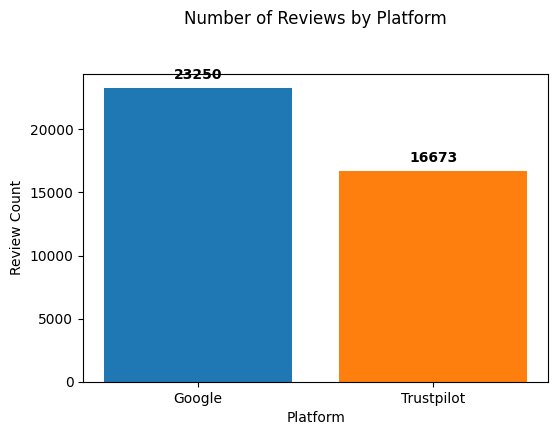

In [ ]:
#import matplotlib.pyplot as plt

# Count reviews per platform
platform_counts = {
    "Google": len(google_df),
    "Trustpilot": len(trustpilot_df)
}

plt.figure(figsize=(6,4))
bars = plt.bar(platform_counts.keys(), platform_counts.values(), color=["#1f77b4", "#ff7f0e"])

# Add counts on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 500, str(yval), ha='center', va='bottom', fontsize=10, fontweight="bold")

plt.title("Number of Reviews by Platform\n\n")
plt.ylabel("Review Count")
plt.xlabel("Platform")
plt.show()

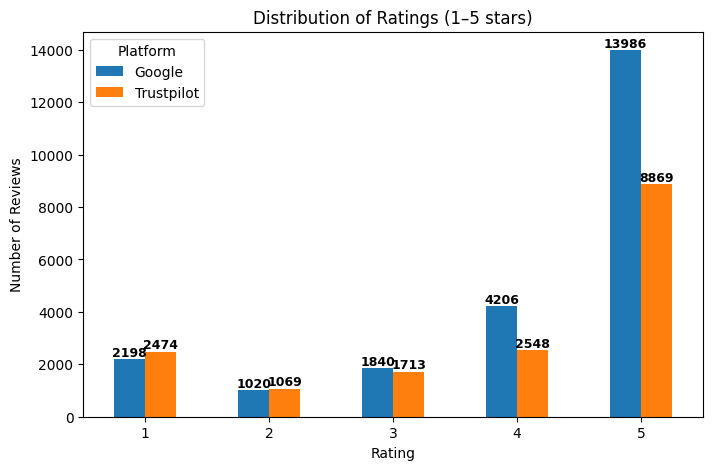

In [ ]:
import pandas as pd

# Combine ratings with platform labels
google_ratings = google_df["Overall Score"].value_counts().sort_index()
trustpilot_ratings = trustpilot_df["Review Stars"].value_counts().sort_index()

ratings_df = pd.DataFrame({
    "Google": google_ratings,
    "Trustpilot": trustpilot_ratings
}).fillna(0).astype(int)

ax = ratings_df.plot(
    kind="bar",
    figsize=(8,5),
    color=["#1f77b4", "#ff7f0e"]
)

plt.title("Distribution of Ratings (1–5 stars)")
plt.xlabel("Rating")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=0)
plt.legend(title="Platform")

# Add counts on top of bars
for container in ax.containers:
    ax.bar_label(container, label_type="edge", fontsize=9, fontweight="bold")

plt.show()


##1.2 Remove rows with missing 'Review Content'/Comments

In [ ]:
#Remove rows with missing 'Review Content'/Comments
trustpilot_df.dropna(subset=['Review Content'],inplace = True) # Trustpilot
google_df.dropna(subset=['Comment'],inplace = True)  #Google


In [ ]:
print(trustpilot_df.info())
print(google_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16673 entries, 0 to 16672
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Review ID                 16673 non-null  object        
 1   Review Created (UTC)      16673 non-null  datetime64[ns]
 2   Review Consumer User ID   16673 non-null  object        
 3   Review Title              16673 non-null  object        
 4   Review Content            16673 non-null  object        
 5   Review Stars              16673 non-null  int64         
 6   Source Of Review          16673 non-null  object        
 7   Review Language           16673 non-null  object        
 8   Domain URL                16673 non-null  object        
 9   Webshop Name              16673 non-null  object        
 10  Business Unit ID          16673 non-null  object        
 11  Tags                      0 non-null      float64       
 12  Company Reply Date

In [ ]:
#rename the columns in google data set to keep the same column name in both dataset

google_df = google_df.rename(columns={
    "Club's Name": "Location Name",
    "Comment": "Review Content",
    "Overall Score": "Review Stars"
})

In [ ]:
trustpilot_df.shape , google_df.shape

((16673, 15), (13898, 7))

##1.2 Remove rows with missing Location

In [ ]:

trustpilot_df.dropna(subset=['Location Name'],inplace = True) # Trustpilot
google_df.dropna(subset=['Location Name'],inplace = True)  #Google

In [ ]:
trustpilot_df.shape , google_df.shape

((11323, 15), (13898, 7))

##1.3 Filter rows based on Review Language

In [ ]:
trustpilot_df = trustpilot_df[trustpilot_df['Review Language']=='en']
len(trustpilot_df)

11290

##1.4 Drop Columns

In [ ]:
trustpilot_df.columns

Index(['Review ID', 'Review Created (UTC)', 'Review Consumer User ID',
       'Review Title', 'Review Content', 'Review Stars', 'Source Of Review',
       'Review Language', 'Domain URL', 'Webshop Name', 'Business Unit ID',
       'Tags', 'Company Reply Date (UTC)', 'Location Name', 'Location ID'],
      dtype='object')

In [ ]:
trustpilot_df.drop(columns=['Review ID',
                            'Review Created (UTC)',
                            'Review Title',
                            'Review Consumer User ID',
                            'Source Of Review',
                            'Review Language',
                            'Domain URL',
                            'Webshop Name',
                            'Business Unit ID',
                            'Tags',
                            'Location ID',
                            'Company Reply Date (UTC)'], axis =1,inplace = True)

In [ ]:
trustpilot_df.shape

(11290, 3)

In [ ]:
trustpilot_df.head(5)

,Review Content,Review Stars,Location Name
0,A very good environment,5,Solihull Sears Retail Park
1,I love to be part of this gym. Superb value fo...,5,Aylesbury
2,"Extremely busy, no fresh air.",1,Sutton Times Square
3,"Great vibes, fantastic gym",5,London Finchley
4,"Clean, well managed, classes are good.",5,Crayford


In [ ]:
google_df.columns

Index(['Customer Name', 'SurveyID for external use (e.g. tech support)',
       'Location Name', 'Social Media Source', 'Creation Date',
       'Review Content', 'Review Stars'],
      dtype='object')

In [ ]:
google_df.drop(columns=['Customer Name',
                        'SurveyID for external use (e.g. tech support)',
                        'Social Media Source',
                        'Creation Date'], axis =1, inplace =True)

In [ ]:
google_df.head(5)

,Location Name,Review Content,Review Stars
1,Cambridge Leisure Park,Too many students from two local colleges go h...,1
2,London Holborn,"Best range of equipment, cheaper than regular ...",5
3,Cheshunt Brookfield Shopping Park,"Good gym when it’s not busy, tend to get too b...",4
4,Bristol Union Gate,"(current member)\n\nGym is quite dirty, more o...",1
5,"209 - Slagelse, Jernbanegade",Kom og betalte for en prøvetime i centret. Fik...,1


In [ ]:
google_df.head(5)

,Location Name,Review Content,Review Stars
1,Cambridge Leisure Park,Too many students from two local colleges go h...,1
2,London Holborn,"Best range of equipment, cheaper than regular ...",5
3,Cheshunt Brookfield Shopping Park,"Good gym when it’s not busy, tend to get too b...",4
4,Bristol Union Gate,"(current member)\n\nGym is quite dirty, more o...",1
5,"209 - Slagelse, Jernbanegade",Kom og betalte for en prøvetime i centret. Fik...,1


#2.Conducting Initial Data Investigation

##2.1 Count Unique Locations

In [ ]:
trustpilot_location_sorted = np.sort(trustpilot_df['Location Name'].astype(str).unique()).tolist()
google_location_sorted = np.sort(google_df['Location Name'].astype(str).unique()).tolist()
print("Unique Locaton in TrustPilot reviews:", len(trustpilot_location_sorted))
print("Unique Locaton in Google reviews:", len(google_location_sorted))


Unique Locaton in TrustPilot reviews: 376
Unique Locaton in Google reviews: 512


##2.2 Count Common Locations

In [ ]:
#Find the number of common locations between the Google data set and the Trustpilot data set.

common_locations = [ e for e in trustpilot_location_sorted if e in google_location_sorted]
print("Number of common location:",len(common_locations))

Number of common location: 310


##2.3 Perform preprocessing of the data
- Perform preprocessing of the data – change to lower case, remove stopwords using NLTK, and remove numbers.
- Tokenise the data using word_tokenize from NLTK.
- Find the frequency distribution of the words from each data set's reviews separately. You can use nltk.freqDist.
- Plot a histogram/bar plot showing the top 10 words from each data set.
- Use the wordcloud library on the cleaned data and plot the word cloud.


Top 10 Words:
         Word  Frequency
0  equipment       3862
1      great       3073
2      staff       3069
3      class       2987
4      clean       2110
5    machine       2063
6       time       1824
7     member       1168
8     shower       1048
9    helpful        975


/tmp/ipython-input-2130848513.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], x="Word", y="Frequency", data=freq_df, palette="viridis")


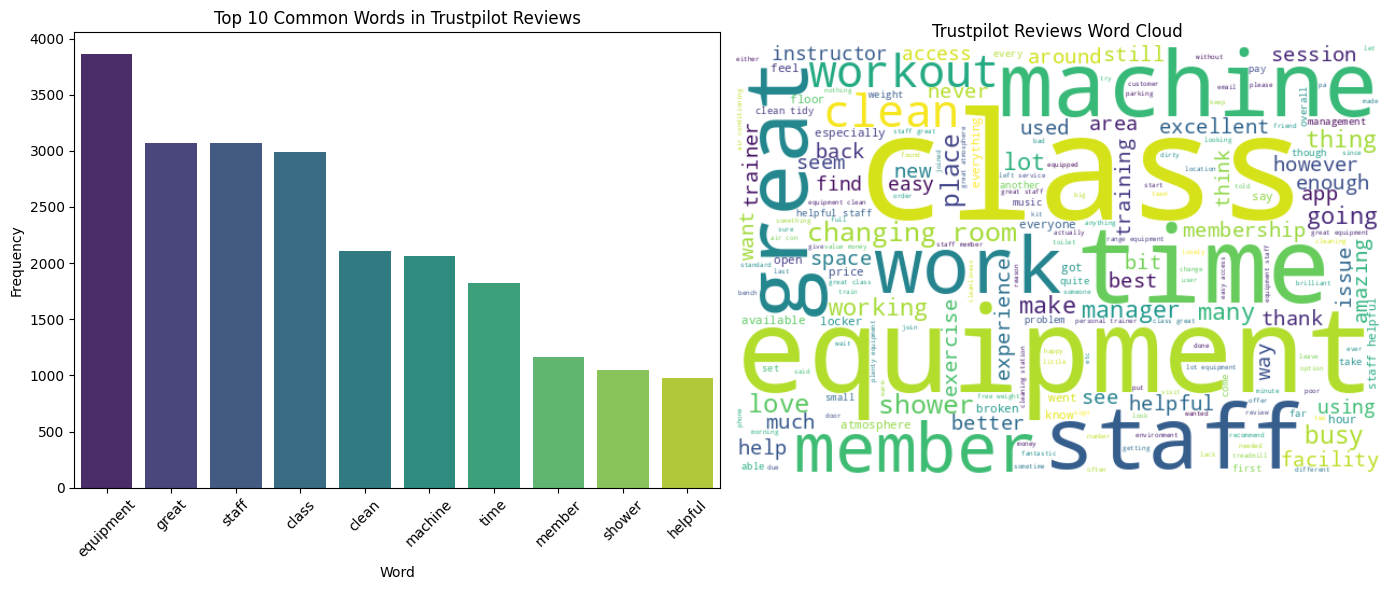

In [ ]:
#import re
#Trustpilot
word_cloud_display(trustpilot_df,'Review Content',"Top 10 Common Words in Trustpilot Reviews","Trustpilot Reviews Word Cloud" )

Top 10 Words:
         Word  Frequency
0  equipment       3783
1      class       3698
2      great       3570
3      staff       2813
4    machine       2349
5       time       2086
6      clean       1865
7      place       1432
8       busy       1181
9     weight       1171


/tmp/ipython-input-2130848513.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], x="Word", y="Frequency", data=freq_df, palette="viridis")


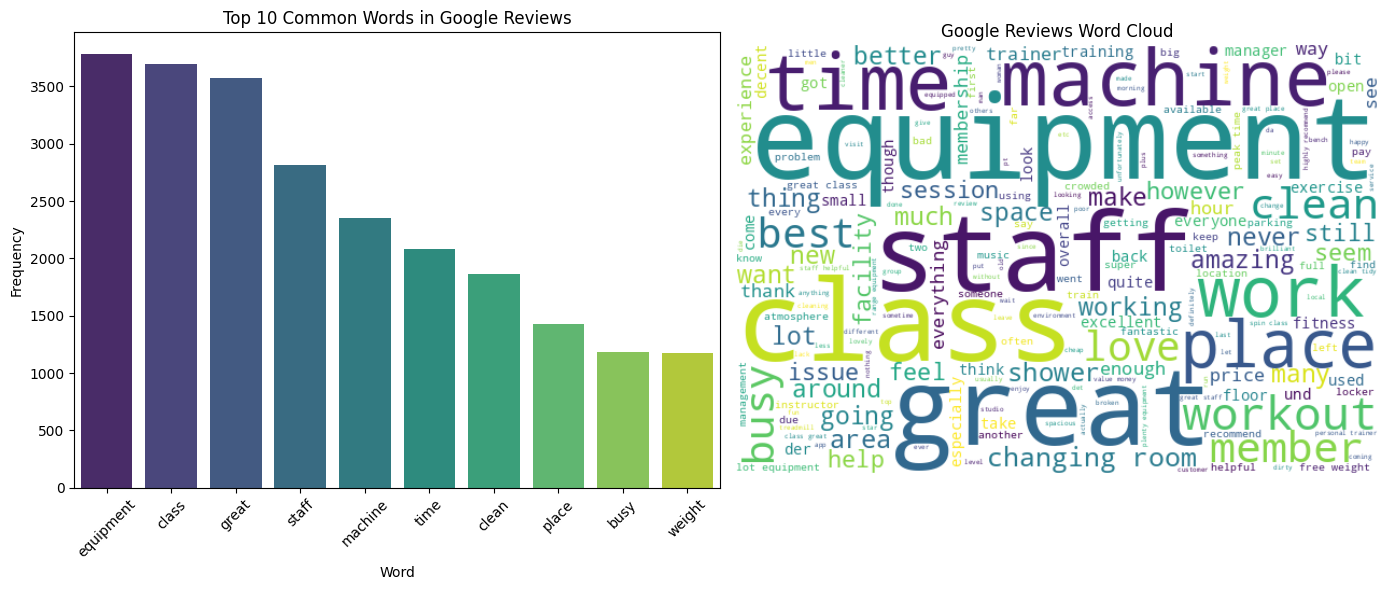

In [ ]:
#Google
word_cloud_display(google_df, 'Review Content',"Top 10 Common Words in Google Reviews","Google Reviews Word Cloud")

##2.4 Create a Dataframe for Negative Reviews

- For Google reviews, overall scores < 3 can be considered negative scores.
- For Trustpilot reviews, stars < 3 can be considered negative scores.

Repeat the frequency distribution and wordcloud steps on the filtered data consisting of only negative reviews.

In [ ]:
#Trustpilot
bad_trustpilot_df= trustpilot_df[trustpilot_df['Review Stars'] <3]
#Google
bad_google_df= google_df[google_df['Review Stars'] <3]


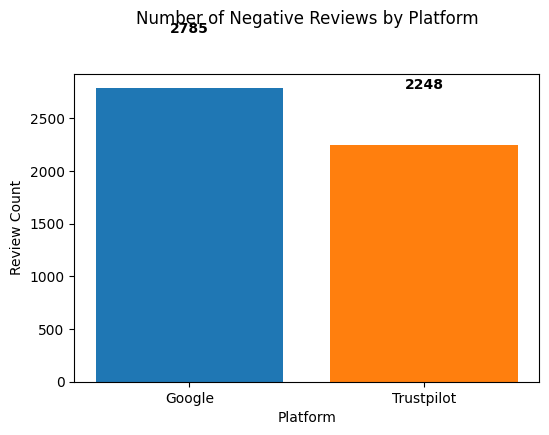

In [ ]:
import matplotlib.pyplot as plt

# Count reviews per platform
platform_counts = {
    "Google": len(bad_google_df),
    "Trustpilot": len(bad_trustpilot_df)
}

plt.figure(figsize=(6,4))
bars = plt.bar(platform_counts.keys(), platform_counts.values(), color=["#1f77b4", "#ff7f0e"])

# Add counts on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 500, str(yval), ha='center', va='bottom', fontsize=10, fontweight="bold")

plt.title("Number of Negative Reviews by Platform\n\n")
plt.ylabel("Review Count")
plt.xlabel("Platform")
plt.show()

/tmp/ipython-input-2130848513.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["processed_comments"] = df[column_name].apply(clean_review)
/tmp/ipython-input-2130848513.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], x="Word", y="Frequency", data=freq_df, palette="viridis")


Top 10 Words:
          Word  Frequency
0   equipment        673
1     machine        646
2        time        613
3      member        572
4       staff        543
5       class        521
6      shower        440
7  membership        392
8        room        324
9        work        317


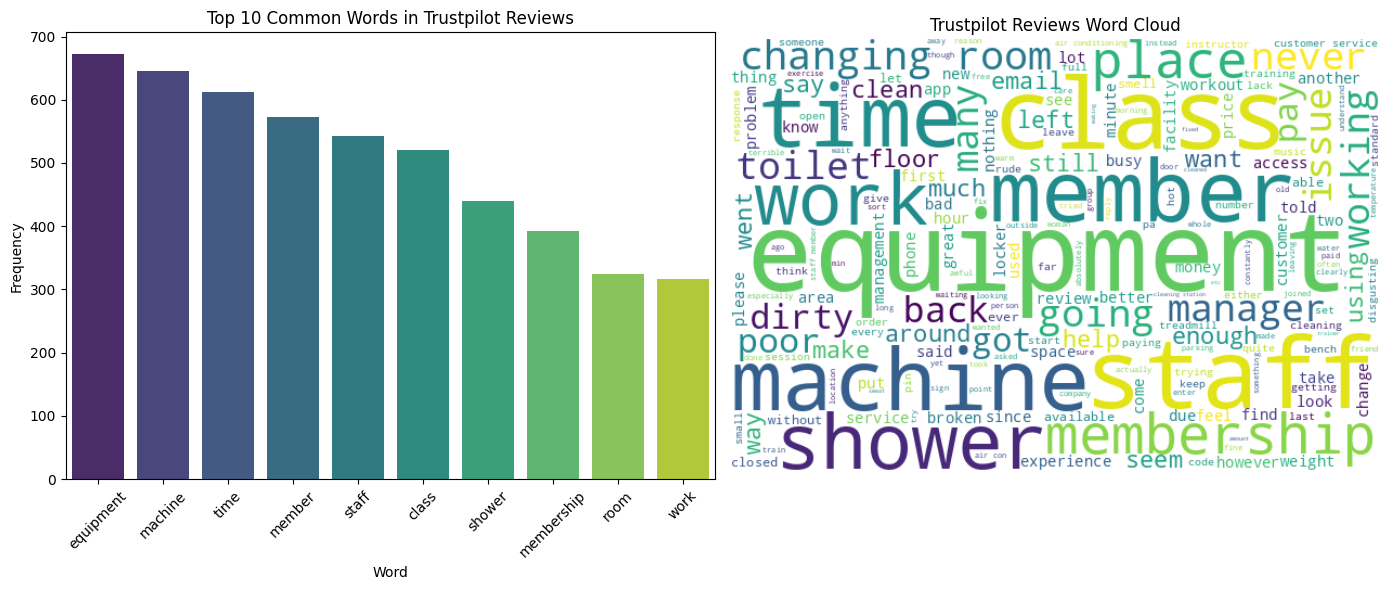

In [ ]:
#Trustpilot
word_cloud_display(bad_trustpilot_df,'Review Content',"Top 10 Common Words in Trustpilot Reviews","Trustpilot Reviews Word Cloud" )

/tmp/ipython-input-2130848513.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["processed_comments"] = df[column_name].apply(clean_review)
/tmp/ipython-input-2130848513.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], x="Word", y="Frequency", data=freq_df, palette="viridis")


Top 10 Words:
          Word  Frequency
0   equipment        944
1     machine        837
2        time        772
3       staff        724
4      member        462
5      weight        423
6       place        420
7  membership        360
8        room        357
9      shower        347


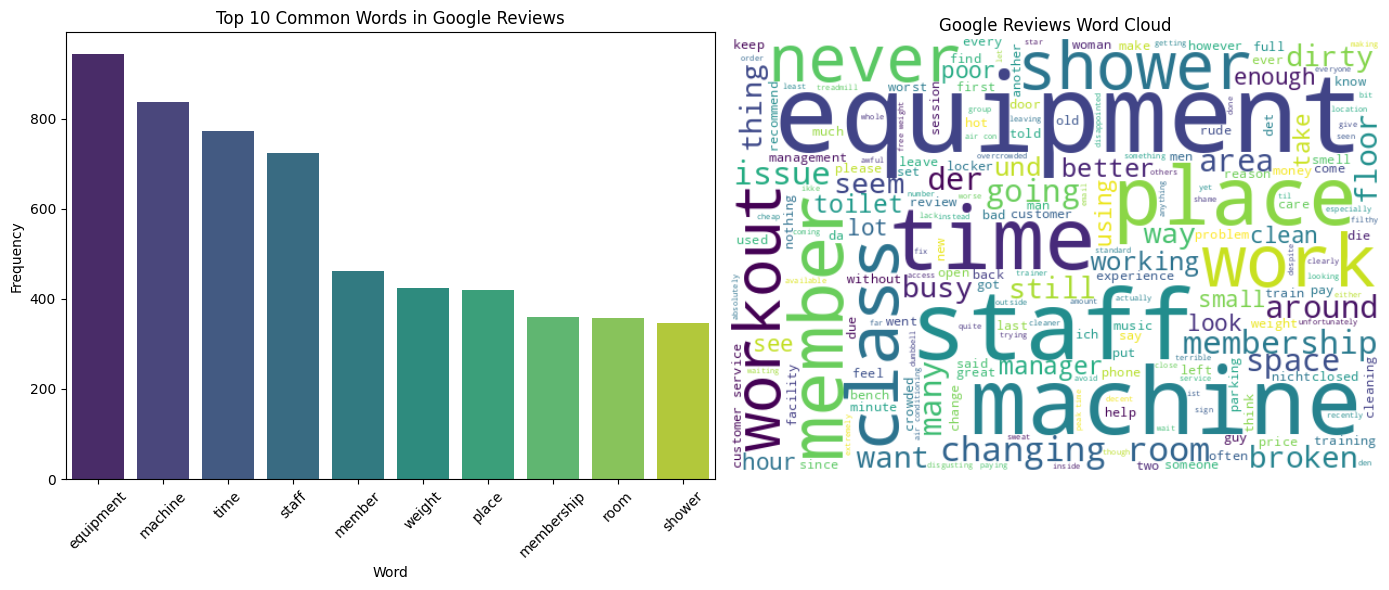

In [ ]:
#Google
word_cloud_display(bad_google_df, 'Review Content',"Top 10 Common Words in Google Reviews","Google Reviews Word Cloud")

#3.Conducting initial topic modelling(BERT)

##3.1 Merge Commom Location Reviews

In [ ]:
#Filter Trustpilot reviews based on common location
bad_trustpilot_both_location_df= bad_trustpilot_df[bad_trustpilot_df['Location Name'].isin(common_locations)]

#Filter Google reviews based on common location
bad_google_both_location_df= bad_google_df[bad_google_df["Location Name"].isin(common_locations)]

In [ ]:
# Merge both datasets(Trustpilot + google)
all_bad_reviews = pd.concat([bad_trustpilot_both_location_df, bad_google_both_location_df], ignore_index=True)

In [ ]:
all_bad_reviews.count()

,0
Review Content,3947
Review Stars,3947
Location Name,3947
processed_comments,3947


In [ ]:
all_bad_reviews.head(3)

,Review Content,Review Stars,Location Name,processed_comments
0,"Extremely busy, no fresh air.",1,Sutton Times Square,extremely busy fresh air
1,The men’s changing rooms smell bad. They need ...,2,Leeds City Centre South,men changing room smell bad deep clean sort sm...
2,No one was cleaning the equipment after use. C...,1,Dunfermline,cleaning equipment cleaning station hidden awa...


In [ ]:
from transformers import pipeline

##3.2 BERTopic Modeling

In [ ]:
!pip install bertopic -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 3.7 MB/s eta 0:00:00


In [ ]:
from bertopic import BERTopic

/usr/local/lib/python3.12/dist-packages/hdbscan/plots.py:448: SyntaxWarning: invalid escape sequence '\l'
  axis.set_ylabel('$\lambda$ value')
/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


In [ ]:
# Apply BERTopic
#topic_model = BERTopic(language="english")
topic_model = BERTopic()
topics, probs = topic_model.fit_transform(all_bad_reviews['processed_comments'])



modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

##3.3 Interactive Visualisation

In [ ]:
topic_model.visualize_topics()
#topic_model.visualize_topics(top_n_topics=10)

##3.4 Bar Chart of the Topics

In [ ]:
# Visualize topics
#topic_model.visualize_topics()
topic_model.visualize_barchart(top_n_topics=10)

##3.5 Heatmap

In [ ]:
topic_model.visualize_heatmap(top_n_topics=20)

##3.6 Top Topics with frequencies

In [ ]:
topic_model.get_topic_freq().head(10)

,Topic,Count
3,-1,1491
11,0,681
6,1,172
17,2,131
7,3,120
30,4,107
15,5,104
22,6,93
1,7,90
27,8,76


It looks like we have a sizeable number of outliers (topic -1) and should typically be ignored.

##3.7 Top words for the top 2 topics

In [ ]:
# Expand display options
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)

topic_model.get_topic_info(0)

Topic  Count                              Name  \
0      0    681  0_machine_equipment_weight_bench   

                                                             Representation  \
0  [machine, equipment, weight, bench, gym, time, cardio, cable, lot, busy]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [ ]:
topic_model.get_topic_info(1)

,Topic,Count,Name,Representation,Representative_Docs
0,1,172,1_air_conditioning_hot_aircon,"[air, conditioning, hot, aircon, con, summer, heat, temperature, warm, working]","[plenty equipment often issue picked staff several locker work properly despite reported management air con appear working signed location new opening soon may tempted seriously finger want lose customer air con seems big issue uncomfortable partake class hiit training due air con unit either functioning blowing warm air reported time reply customer service every time regard temperature air conditioning unit heat air drop cool air go higher keeping temperature within acceptable level regularly checked ensure unit operating across gym, air con seems big issue uncomfortable partake class hiit training due air con unit either functioning blowing warm air reported time reply customer service every time regard temperature air conditioning unit heat air drop cool air go higher keeping temperature within acceptable level regularly checked ensure unit operating across gym, air conditioning]"


In [ ]:
topic_model.get_topic_info().head(11)

Topic  Count                                   Name  \
0      -1   1491       -1_staff_member_shower_equipment   
1       0    681       0_machine_equipment_weight_bench   
2       1    172          1_air_conditioning_hot_aircon   
3       2    131    2_class_instructor_booked_cancelled   
4       3    120                3_parking_car_fine_park   
5       4    107              4_locker_stolen_lock_room   
6       5    104                5_music_loud_hear_noise   
7       6     93            6_closed_open_christmas_day   
8       7     90              7_toilet_dirty_smell_room   
9       8     76  8_cancel_account_membership_suspended   
10      9     59               9_shower_dirty_cold_mold   

                                                                          Representation  \
0       [staff, member, shower, equipment, time, room, toilet, changing, machine, place]   
1               [machine, equipment, weight, bench, gym, time, cardio, cable, lot, busy]   
2        [air, conditioning, hot, aircon, con, summer, heat, temperature, warm, working]   
3    [class, instructor, booked, cancelled, booking, minute, spin, induction, time, min]   
4                    [parking, car, fine, park, free, ticket, reg, website, enter, hour]   
5           [locker, stolen, lock, room, padlock, bag, broken, changing, damaged, staff]   
6               [music, loud, hear, noise, headphone, class, volume, play, ear, playing]   
7      [closed, open, christmas, day, email, communication, opening, time, notice, door]   
8        [toilet, dirty, smell, room, mirror, changing, clean, smelly, sink, disgusting]   
9   [cancel, account, membership, suspended, email, refund, fee, direct, payment, debit]   
10              [shower, dirty, cold, mold, water, fix, sort, changing, working, broken]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

**Summary of Top 10 Clusters**
1) **Equipment issues (layout, broken machines, availability)**

    **Top words**: machine, equipment, weight, bench, gym, time, rack, busy, cardio, enough
    
    **Theme**: Broken or insufficient equipment, machines in poor condition, difficulty accessing weights due to crowding.

2) **Air conditioning & cleanliness**
    
    **Top words:** air, toilet, cleaning, smell, room, changing, dirty, equipment, conditioning, clean

    **Issue:** Problems with air conditioning, cleanliness, and unpleasant smells in changing rooms.

3) **Classes & instructors**

    **Top words:** class, instructor, booked, cancelled, spin, minute, time, booking, min, attend
    
    **Theme:** Cancelled or poorly managed classes, instructor issues, booking frustrations.

4) **Parking & fines**

    **Top words:** parking, car, fine, park, free, ticket, reg, hour, website, enter

    **Theme:** Parking difficulties and fines, confusion over free parking, registration problems.

5) **Lockers & theft/security**

    **Top words:** locker, bag, room, stolen, lock, padlock, broken, changing, staff, safe

    **Theme:** Stolen items from lockers, broken locks, unsafe locker rooms.

6) **Loud music / noise in classes**

    **Top words:** music, loud, class, hear, noise, headphone, volume, play, ear, playing

    **Theme:** Music too loud, customers can’t hear, complaints about noise in classes and gym floor.

7) **Unexpected closures & communication gaps**

    **Top words:** closed, open, christmas, day, email, opening, communication, time, notice, door
    
    **Theme:** Gyms unexpectedly closed, poor communication about opening times (e.g., Christmas Day).

8) **Dirty and smelling toilet**

    **Top words:** toilet, dirty, smell, room, mirror, changing, clean, smelly, sink, disgusting

    **Theme:** Diffunhappy with cleanliness, Strong complaints about bad odors, Facility mismanagement

9) **Joining fees & app-related issues**

    **Top words:** joining, fee, app, membership, code, discount, sign, access, pay, charged

    **Theme:** Problems with joining fees, app-related issues, promotions not honoured.

10) **Showers & hot water**

    **Top words:** shower, cold, water, hot, temperature, freezing, changing, room, warm, dirty

    **Theme:** Cold/freezing showers, water temperature problems, unclean shower areas.


  

#4.Performing further data investigation

##4.1 Top 20 locations with the highest number of Negative Reviews

In [ ]:
trustpilot_top20 = (
    bad_trustpilot_df
    .groupby("Location Name")
    .size()
    .reset_index(name="TP_Total_Count")
    .sort_values("TP_Total_Count", ascending=False)

)

trustpilot_top20.head(20)


,Location Name,TP_Total_Count
155,Leicester Walnut Street,50
0,345,45
186,London Enfield,23
219,London Stratford,22
58,Burnham,20
171,London Bermondsey,18
199,London Ilford,18
188,London Finchley,16
215,London Seven Sisters,16
233,Maidenhead,16


In [ ]:
#Google
google_top20 = (
    bad_google_df
    .groupby("Location Name")
    .size()
    .reset_index(name="G_Total_Count")
    .sort_values("G_Total_Count", ascending=False)

)
google_top20.head(20)

,Location Name,G_Total_Count
319,London Stratford,59
330,London Woolwich,26
275,London Canary Wharf,26
285,London Enfield,25
321,London Swiss Cottage,24
311,London Palmers Green,22
124,Birmingham City Centre,21
303,London Leytonstone,21
353,New Barnet,20
137,Bradford Thornbury,19


## 4.2 Merge the 2 Data sets(Trustpilot_Top20 + Google_Top20)

In [ ]:
#Merge the Trustpilot and Google dataframes
merged_location_bad_reviews_count_df = pd.merge(trustpilot_top20,
                                                google_top20,
                                                how= 'left',
                                                left_on= 'Location Name',
                                                right_on="Location Name"
)
#Calculate total bad reviews per location
merged_location_bad_reviews_count_df['total_count'] = merged_location_bad_reviews_count_df['TP_Total_Count'] + merged_location_bad_reviews_count_df['G_Total_Count']

#Sort locations by total bad reviews
merged_location_bad_reviews_count_df_sorted = merged_location_bad_reviews_count_df.sort_values(by=['total_count'], ascending=False)

merged_location_bad_reviews_count_df_sorted.head(20)

,Location Name,TP_Total_Count,G_Total_Count,total_count
3,London Stratford,22,59.0,81.0
0,Leicester Walnut Street,50,11.0,61.0
2,London Enfield,23,25.0,48.0
12,London Swiss Cottage,15,24.0,39.0
19,Birmingham City Centre,14,21.0,35.0
16,New Barnet,14,20.0,34.0
5,London Bermondsey,18,16.0,34.0
8,London Seven Sisters,16,18.0,34.0
20,Bradford Thornbury,14,19.0,33.0
11,London Hayes,16,17.0,33.0


##4.3 Top 30 Locations

Create a Dataframe for Top 30 locations

In [ ]:
top30_location= merged_location_bad_reviews_count_df_sorted.head(30)

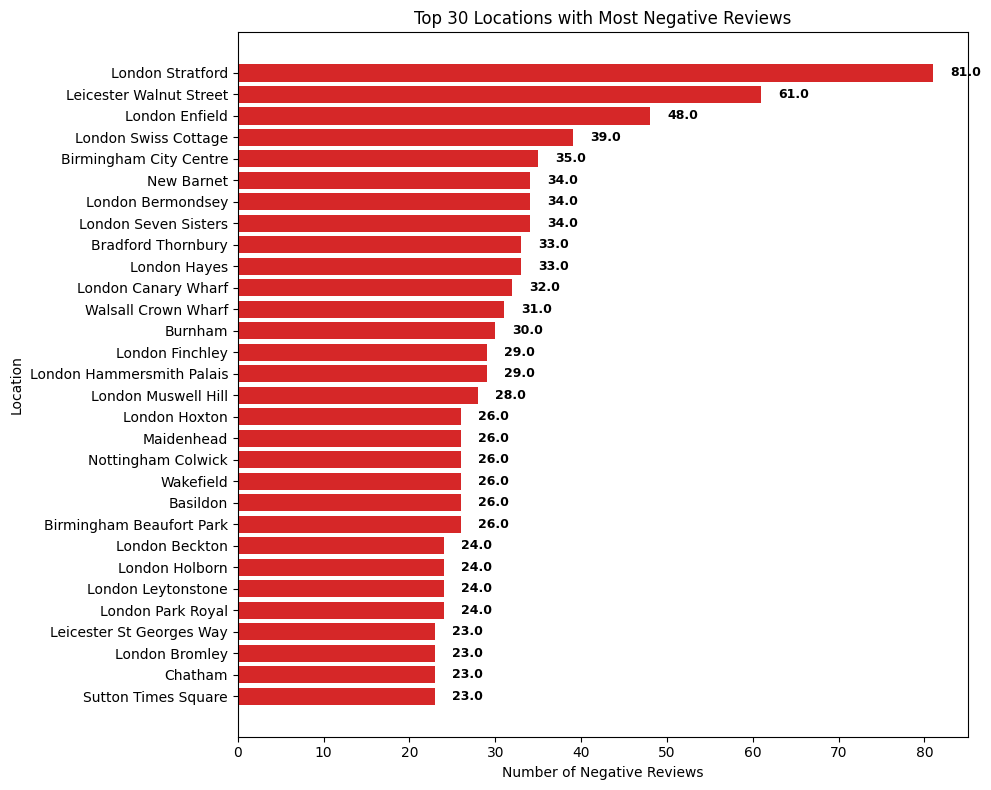

In [ ]:
# Plot horizontal bar chart
plt.figure(figsize=(10,8))
bars = plt.barh(top30_location["Location Name"][::-1],
                top30_location["total_count"][::-1],
                color="#d62728")

# Add count labels on bars
for i, v in enumerate(top30_location["total_count"][::-1]):
    plt.text(v + 2, i, str(v), va="center", fontsize=9, fontweight="bold")

plt.title("Top 30 Locations with Most Negative Reviews")
plt.xlabel("Number of Negative Reviews")
plt.ylabel("Location")
plt.tight_layout()
plt.show()



In [ ]:
#create a list of Top 30 locations
top30_location= merged_location_bad_reviews_count_df_sorted['Location Name'].head(30).astype(str).tolist()

#trustpilot_location_sorted = np.sort(trustpilot_df['Location Name'].astype(str).unique()).tolist()

In [ ]:

top30_location[1]

'Leicester Walnut Street'

In [ ]:
#create a dataframe of Trustpilot bad reviews for Top 30 locations
tp_top30_reviews_df = bad_trustpilot_df[bad_trustpilot_df['Location Name'].isin(top30_location)]

#create a dataframe of Google bad reviews for Top 30 locations
g_top30_reviews_df = bad_google_df[bad_google_df['Location Name'].isin(top30_location)]



## 4.4 Top 30 Location - Word Frequency and Word cloud

Top 10 Words:
         Word  Frequency
0     member        138
1    machine        120
2       time        114
3  equipment        110
4     shower        110
5      staff         90
6     toilet         75
7    manager         72
8       room         70
9      class         65


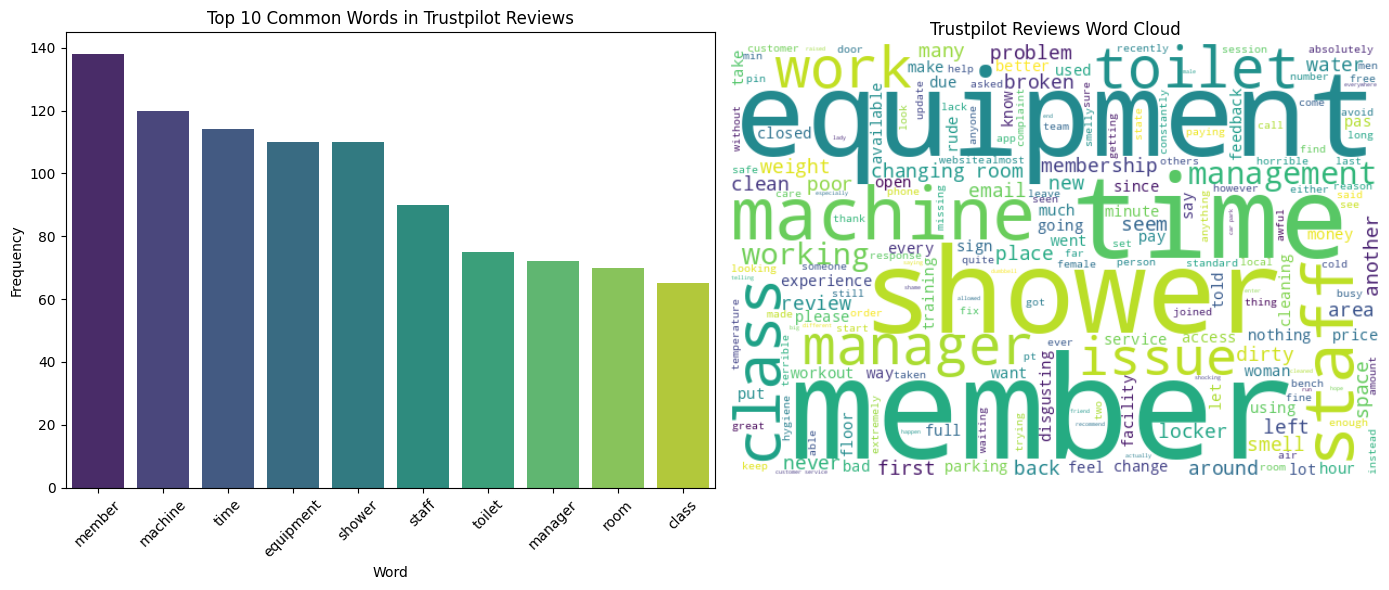

In [ ]:
#World cloud for Trustpilot Top30 bad reviews
word_cloud_display(tp_top30_reviews_df,'Review Content',"Top 10 Common Words in Trustpilot Reviews","Trustpilot Reviews Word Cloud" )


Top 10 Words:
          Word  Frequency
0     machine        203
1   equipment        176
2       staff        160
3        time        152
4      member        111
5       place         96
6      weight         92
7  membership         91
8      toilet         89
9        room         82


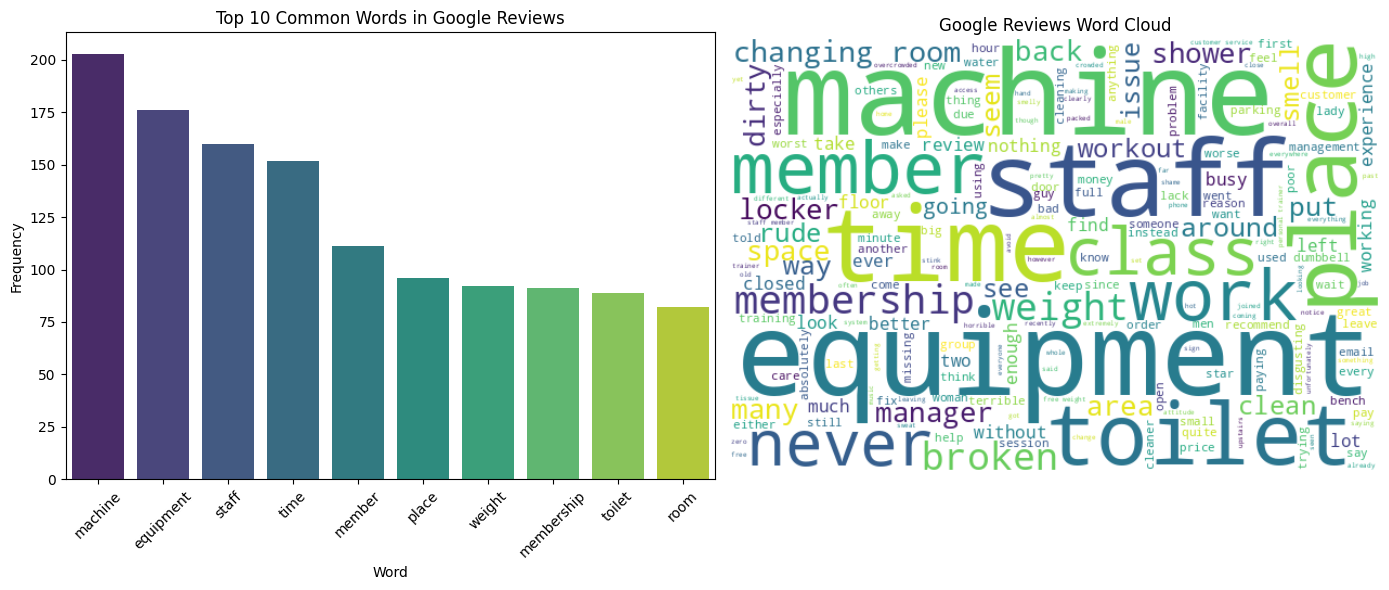

In [ ]:
#World cloud for Google Top30 bad reviews
word_cloud_display(g_top30_reviews_df, 'Review Content',"Top 10 Common Words in Google Reviews","Google Reviews Word Cloud")

##4.5 Merge the 2 Data Sets for Top30 locations

In [ ]:
# Combine Trustpilot + Google reviews for top 30
combined_top30_reviews_df = pd.concat([tp_top30_reviews_df, g_top30_reviews_df], axis=0).reset_index(drop=True)

#combined_top30_reviews_df

##4.6 BERTTopic Modeling for Top 30 Locations Reviews

In [ ]:
# Apply BERTopic
#topic_model_top30 = BERTopic(language="english")
topic_model = BERTopic()

topics, probs = topic_model.fit_transform(combined_top30_reviews_df['processed_comments'])

In [ ]:

topic_model.get_topic_freq().head(10)

,Topic,Count
1,-1,331
0,0,177
2,1,92
10,2,51
8,3,51
11,4,43
6,5,39
5,6,36
3,7,31
9,8,20


In [ ]:
topic_model.visualize_topics()
topic_model.visualize_barchart(top_n_topics=10)

In [ ]:
topic_model.get_topic_info().head(11)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,331,-1_machine_equipment_time_membership,"[machine, equipment, time, membership, staff, weight, place, member, toilet, broken]","[truly abysmal hayes paying almost foul rotten egg urine smell coming sink men changing room fixed month stink every fountain water machine broken every fill water bottle training yanga machine lock disabled toilet broken broken many occasion hot make feel open sauna full sweat water leak coming roof every poor equipment leg press machine hack squat seated hamstring curl despite member concurrently peak hour member going year gradually gone hill severely past new staff come new manager walk talk hood rat care much anything constantly neglected despite much member paying extortionate horrific, member year year green track covered temporary although pretty permanent wall orange barricade somewhere whether functional area side rig reducing space available member elsewhere every time surprised machine order sign become norm never get permanent fix temporary let honest never last long shocked surprised emergency button working sign next saying case emergency call landline number speak cctv person mean come joke declined rapidly last start pt leaving blame honest light flashing constantly free weight area section light clearly work air con absolutely rubbish hardly ever say impressed understatement become joke laughing every time see else working used med ball around anymore nothing get replaced used way box think since member creepy member odd stare whilst lift obviously absolutely astounded find ago physically avoid specific member dodgy strange overall putting come make conversation tell working hard enough firstly lost judge someone else training secondly month ago walked find actually bcc wow stooped low creepy member thing employing someone new low hear stuff going pt apparently allowed name tell truth surprised surprised another apparently allowed name person either pt caught honestly though aron jimmy leave bcc going downhill pt left already, pay multi membership pay seven sister included list gym bit ridiculous shrugged min away home thought save travelling way finsbury park tube honestly disappointed utilise space small feel exposed treadmill stairmasters directly infront bus stop girl probably stared glass studio light seem set timer switch back amount time light glarey floor exercise got find spot underneath light many bar weight studio barbell decent amount variety machine though ever wait machine since going seen cleaning station around yet great considering wipe yoga mat disappointing thing upstairs changing area separated male female changing room cubicle btw usually dirty rubbish individual unisex toilet cubicle never clean literally poo stain every time lol locker pretty small unlucky exposed cupboard leave thing come seven sister hardly safe leave anything better yet carry belonging around pro variety machine weight ceiling tall feel spacious con actually small seem get cleaned often single water fountain member drink machine thought gym paying premium membership changing area unisex comfortable seeing walking around naked already closed consecutive day maintenance announced last minute new impressed offer probably going set finsbury park main every aspect much worth money]"
1,0,177,0_toilet_air_cleaning_smell,"[toilet, air, cleaning, smell, dirty, equipment, room, smelly, hand, changing]","[main issue extremely dirty toilet constantly order staff never fire alarm went staff evacuate machine broken week time fix every single womens toilet lock toilet make look used toilet main area piled rubbish pee seat clean place staff sit around seems cleaner everything dirty machine constantly broken fixed body mass scale paper replaced week recently going staff sign sunday staff new year ever sign fire alarm staff evacuated sign staff genuinely going leave getting unsafe, something change last year going downhill downhill let start ongoing l

**Initial Run (Topics 0–9)**

- Broad themes: air-conditioning/smell, equipment, showers, classes, parking, lockers/theft, loud music, closures, membership cancellation, joining fees.

- Topics are high-level categories that grouped multiple related complaints together.

- Example: Topic 0 combined air-conditioning + cleanliness + smell.

**Top 30 Location Run (Topics 0–9)**

- Topics are narrower and more specific.

- New issues appeared that weren’t visible (or were buried) in the first run:

  - Staff rudeness / management behaviour (Topic 2).

  - PIN/passcode access problems (Topic 5).

  - Yanga water machine / paid water refill complaints (Topic 9).

- Some older themes split into finer categories:

  - Air-conditioning issues got their own smaller cluster (Topic 7), instead of being lumped with cleanliness/smell.

  - Showers became more focused on “dirty/mould/fix” (Topic 3).

- Membership-related complaints split:

  - App/account suspension (Topic 8).

  - Joining fee issues were dropped, replaced by water machine complaints.

**What Changed**

  - Granularity improved — more specific clusters, less mixing of issues.

 - Topic frequency distribution changed — in the second run, counts are smaller (max ~122 vs ~759 before) because topics are narrower.

 - New actionable insights appeared: PIN code access problems, Yanga water machine dissatisfaction, rude staff/manager issues.

**Additional Insights Compared to First Run**

 - Operational issues like PIN code failures and water machine charges are clearly highlighted now.

  - Staff behaviour and management rudeness emerges as a distinct area of dissatisfaction.

 - Air-conditioning is seen as a standalone recurring complaint (not buried under cleanliness).

- The more focused clusters give clearer action points: e.g., “fix PIN access” or “train managers on customer service” instead of a generic “membership issues.”

**Summary**

Compared to the initial BERTopic run, the Top 30 location run produced more fine-grained clusters. While the initial run highlighted broad issues (e.g., cleanliness, equipment, membership), the top location run uncovered additional, more specific themes such as staff rudeness, PIN access problems, and dissatisfaction with paid water machines. Existing themes (e.g., showers, air conditioning) also split into clearer, more focused clusters. This provides richer, more actionable insights for PureGym’s operations and customer experience improvement.

#5.Conducting Emotion Analysis

##5.1 Import the BERT

In [ ]:
#Import the BERT model bhadresh-savani/bert-base-uncased-emotion from Hugging Face, and set up a pipeline for text classification.
classifier = pipeline("text-classification", model='bhadresh-savani/bert-base-uncased-emotion', return_all_scores=True)

#Import the BERT model bhadresh-savani/bert-base-uncased-emotion from Hugging Face, and set up a pipeline for text classification.

config.json:   0%|          | 0.00/935 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu


##5.2 Emotion Analysis on Example Sentence

In [ ]:
#Test on one prompt
#With the help of an example sentence, run the model and display the different emotion classifications that the model outputs.
test_prompt = "The food tasted great, but it took forever to arrive."
#Wow, best experience ever... if you enjoy waiting an hour for cold food."
#Not good."
#Amazing service, I will definitely come back again!

prediction = classifier(test_prompt,)
print(prediction)

# Sort emotions by score
emotion_labels_sorted = sorted(prediction[0], key=lambda x: x["score"], reverse=True)
print(emotion_labels_sorted)

[[{'label': 'sadness', 'score': 0.0006136837764643133}, {'label': 'joy', 'score': 0.9975274205207825}, {'label': 'love', 'score': 0.0006321725668385625}, {'label': 'anger', 'score': 0.00041540456004440784}, {'label': 'fear', 'score': 0.00035578294773586094}, {'label': 'surprise', 'score': 0.0004555917694233358}]]
[{'label': 'joy', 'score': 0.9975274205207825}, {'label': 'love', 'score': 0.0006321725668385625}, {'label': 'sadness', 'score': 0.0006136837764643133}, {'label': 'surprise', 'score': 0.0004555917694233358}, {'label': 'anger', 'score': 0.00041540456004440784}, {'label': 'fear', 'score': 0.00035578294773586094}]


In [ ]:
def batch_emotion_classify(reviews, classifier, batch_size=32):
    """
    Classify a list of reviews in batches using the Hugging Face pipeline.
    Returns a list of top emotion dicts.
    """
    top_emotions = []
    for i in range(0, len(reviews), batch_size):
        batch = reviews[i:i+batch_size]
        predictions = classifier(batch)
        for pred in predictions:
            top_emotion = max(pred, key=lambda x: x["score"])
            top_emotions.append(top_emotion)
    return top_emotions

##5.3 Emotion Analysis on both(Trustpilot & Google) dataset

In [ ]:
#Prepare a list of cleaned reviewes
all_bad_reviews_list_clean = all_bad_reviews['processed_comments'].astype(str).tolist()

In [ ]:
# Run this model on both data sets, and capture the top emotion for each review
top_emotions = batch_emotion_classify(all_bad_reviews_list_clean, classifier, batch_size=32)


In [ ]:
top_emotions[0]

{'label': 'joy', 'score': 0.8585655689239502}

In [ ]:
#Extract labels
top_emotion_labels = [e['label'] for e in top_emotions]

print(top_emotion_labels)

['joy', 'joy', 'sadness', 'joy', 'sadness', 'joy', 'joy', 'sadness', 'anger', 'fear', 'sadness', 'anger', 'sadness', 'sadness', 'anger', 'joy', 'joy', 'sadness', 'sadness', 'sadness', 'joy', 'sadness', 'fear', 'sadness', 'joy', 'love', 'sadness', 'joy', 'sadness', 'joy', 'sadness', 'anger', 'sadness', 'joy', 'joy', 'sadness', 'joy', 'joy', 'anger', 'anger', 'joy', 'sadness', 'anger', 'anger', 'joy', 'anger', 'anger', 'sadness', 'fear', 'anger', 'anger', 'joy', 'fear', 'joy', 'anger', 'sadness', 'fear', 'joy', 'anger', 'anger', 'joy', 'anger', 'anger', 'anger', 'joy', 'anger', 'joy', 'sadness', 'joy', 'joy', 'joy', 'anger', 'anger', 'anger', 'anger', 'anger', 'joy', 'joy', 'joy', 'joy', 'joy', 'anger', 'anger', 'anger', 'anger', 'joy', 'anger', 'anger', 'sadness', 'anger', 'joy', 'anger', 'sadness', 'anger', 'fear', 'fear', 'sadness', 'joy', 'sadness', 'joy', 'joy', 'sadness', 'anger', 'joy', 'anger', 'joy', 'sadness', 'joy', 'joy', 'anger', 'joy', 'anger', 'anger', 'fear', 'love', 'joy

In [ ]:
#Count emotions
emotion_counts= pd.Series(top_emotion_labels).value_counts().reset_index()
emotion_counts.columns = ['Emotion', 'Count']


In [ ]:
emotion_counts

,Emotion,Count
0,anger,1411
1,sadness,1182
2,joy,1005
3,fear,217
4,love,91
5,surprise,41


##5.4 Bar Plot for Top Emotions

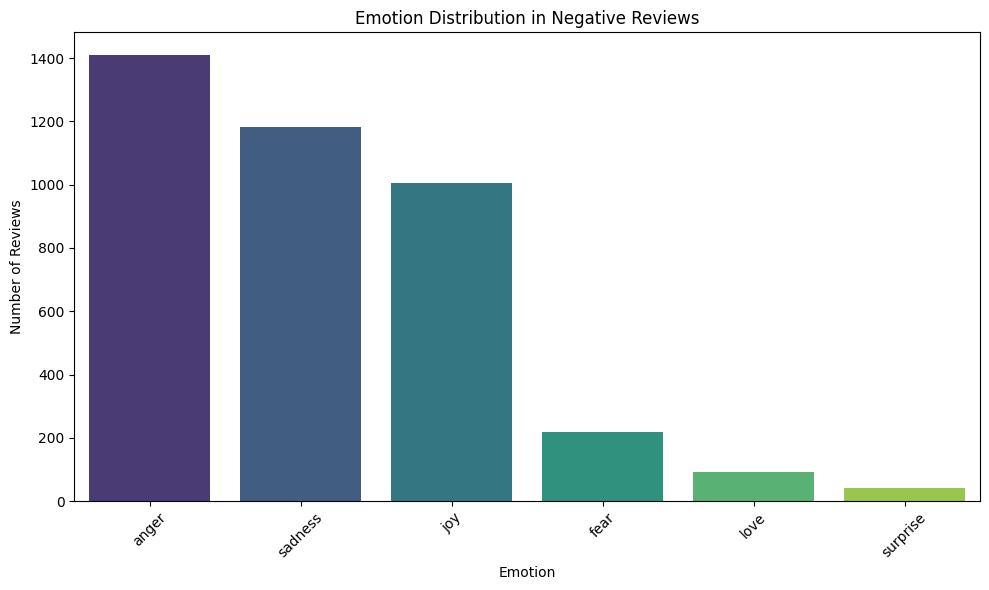

In [ ]:
#Use a bar plot to show the top emotion distribution for all negative reviews in both data sets.
plt.figure(figsize= (10,6))
sns.barplot(data= emotion_counts,
            x='Emotion',
            y='Count',
            palette = 'viridis')

plt.title("Emotion Distribution in Negative Reviews")
plt.xlabel("Emotion")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##5.5 Negative Reviews for Anger Emotion

In [ ]:
#Extract all the negative reviews (from both data sets) where anger is top emotion.
anger_reviews = [review for review, emotion in zip(all_bad_reviews_list_clean, top_emotion_labels)
    if emotion == 'anger'
]

anger_reviews[0]


'blocked access take work meet idiot manager want lose money job recommend anyone found touched green box height door handle found touched green box right took money account remember call bank request refund account refund registered office address town centre house merrion centre leeds'

In [ ]:
max = 15
for i in range(max):
  print(f'Review {i} : {anger_reviews[i]}')

Review 0 : blocked access take work meet idiot manager want lose money job recommend anyone found touched green box height door handle found touched green box right took money account remember call bank request refund account refund registered office address town centre house merrion centre leeds
Review 1 : awful experience joining let buddy membership tried bolt friend website useless telling issue bought expensive pas end freaked multiple time payment went email pin took age send absolutely awful discourages greatly using different gym chain email sent write review demanding tone rude
Review 2 : worse leicester
Review 3 : beckton staff aggressive violent thought safe place protected staff case staff one charge square face wanting fight avoid cost protected staff complaint procedure bad book think twice attack threaten violence exactly happened tuesday day ago since management team say still investigating confront trainer client asked hogging machine whilst taking minute break though 

In [ ]:
print(f"Number of reviews with anger as top emotion: {len(anger_reviews)}")
print(anger_reviews[:5])

Number of reviews with anger as top emotion: 1411
['blocked access take work meet idiot manager want lose money job recommend anyone found touched green box height door handle found touched green box right took money account remember call bank request refund account refund registered office address town centre house merrion centre leeds', 'awful experience joining let buddy membership tried bolt friend website useless telling issue bought expensive pas end freaked multiple time payment went email pin took age send absolutely awful discourages greatly using different gym chain email sent write review demanding tone rude', 'worse leicester', 'beckton staff aggressive violent thought safe place protected staff case staff one charge square face wanting fight avoid cost protected staff complaint procedure bad book think twice attack threaten violence exactly happened tuesday day ago since management team say still investigating confront trainer client asked hogging machine whilst taking min

##5.6 Run BERT

In [ ]:
#Run BERTopic on the output of the previous step.
"""
model = BERTopic(verbose= True)
model.fit(all_bad_reviews_list_clean)
topic, probabilities = model.transform(anger_reviews)
"""
model = BERTopic(verbose=True)
topics, probabilities = model.fit_transform(anger_reviews)

2025-09-23 11:42:39,595 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/45 [00:00<?, ?it/s]

2025-09-23 11:43:08,514 - BERTopic - Embedding - Completed ✓
2025-09-23 11:43:08,515 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-09-23 11:43:13,725 - BERTopic - Dimensionality - Completed ✓
2025-09-23 11:43:13,727 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-09-23 11:43:13,822 - BERTopic - Cluster - Completed ✓
2025-09-23 11:43:13,830 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-09-23 11:43:13,963 - BERTopic - Representation - Completed ✓


In [ ]:
model.get_topic_freq().head(11)

,Topic,Count
1,-1,332
8,0,204
5,1,127
7,2,95
0,3,93
4,4,73
13,5,49
6,6,43
18,7,41
10,8,39


In [ ]:
# Visualize topics
topic_model.visualize_topics()
topic_model.visualize_barchart(top_n_topics=10)

In [ ]:
topic_model.get_topic_info().head(11)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,331,-1_machine_equipment_time_membership,"[machine, equipment, time, membership, staff, weight, place, member, toilet, broken]","[truly abysmal hayes paying almost foul rotten egg urine smell coming sink men changing room fixed month stink every fountain water machine broken every fill water bottle training yanga machine lock disabled toilet broken broken many occasion hot make feel open sauna full sweat water leak coming roof every poor equipment leg press machine hack squat seated hamstring curl despite member concurrently peak hour member going year gradually gone hill severely past new staff come new manager walk talk hood rat care much anything constantly neglected despite much member paying extortionate horrific, member year year green track covered temporary although pretty permanent wall orange barricade somewhere whether functional area side rig reducing space available member elsewhere every time surprised machine order sign become norm never get permanent fix temporary let honest never last long shocked surprised emergency button working sign next saying case emergency call landline number speak cctv person mean come joke declined rapidly last start pt leaving blame honest light flashing constantly free weight area section light clearly work air con absolutely rubbish hardly ever say impressed understatement become joke laughing every time see else working used med ball around anymore nothing get replaced used way box think since member creepy member odd stare whilst lift obviously absolutely astounded find ago physically avoid specific member dodgy strange overall putting come make conversation tell working hard enough firstly lost judge someone else training secondly month ago walked find actually bcc wow stooped low creepy member thing employing someone new low hear stuff going pt apparently allowed name tell truth surprised surprised another apparently allowed name person either pt caught honestly though aron jimmy leave bcc going downhill pt left already, pay multi membership pay seven sister included list gym bit ridiculous shrugged min away home thought save travelling way finsbury park tube honestly disappointed utilise space small feel exposed treadmill stairmasters directly infront bus stop girl probably stared glass studio light seem set timer switch back amount time light glarey floor exercise got find spot underneath light many bar weight studio barbell decent amount variety machine though ever wait machine since going seen cleaning station around yet great considering wipe yoga mat disappointing thing upstairs changing area separated male female changing room cubicle btw usually dirty rubbish individual unisex toilet cubicle never clean literally poo stain every time lol locker pretty small unlucky exposed cupboard leave thing come seven sister hardly safe leave anything better yet carry belonging around pro variety machine weight ceiling tall feel spacious con actually small seem get cleaned often single water fountain member drink machine thought gym paying premium membership changing area unisex comfortable seeing walking around naked already closed consecutive day maintenance announced last minute new impressed offer probably going set finsbury park main every aspect much worth money]"
1,0,177,0_toilet_air_cleaning_smell,"[toilet, air, cleaning, smell, dirty, equipment, room, smelly, hand, changing]","[main issue extremely dirty toilet constantly order staff never fire alarm went staff evacuate machine broken week time fix every single womens toilet lock toilet make look used toilet main area piled rubbish pee seat clean place staff sit around seems cleaner everything dirty machine constantly broken fixed body mass scale paper replaced week recently going staff sign sunday staff new year ever sign fire alarm staff evacuated sign staff genuinely going leave getting unsafe, something change last year going downhill downhill let start ongoing l

This run retains the core themes from earlier analyses but partially re-merges hygiene issues into a broad “toilets/changing/odour” topic 0, reducing the fine granularity achieved in the Second run. However, highly actionable clusters remain intact—PIN/email access failures, parking/validation fines, Yanga water/time-limits/broken fountains, showers (dirty/cold), equipment disorder/breakages, and staff/manager behaviour.

#6.Large language Model from Hugging Face

<font color="red">"For LLM , please refer  the other sheet named Badoni_Vipin_CAM_C301_Week_4and5_Topic_project_LLM.ipynb"</font>

#7.Gensim

In [ ]:
#save the 'all_bad_reviews' to a file in google drive
import pickle

with open("/content/drive/MyDrive/Colab Notebooks/Course 3/Project/all_bad_reviews.pkl","wb") as f:
  pickle.dump({"all_bad_reviews": all_bad_reviews}, f)


In [ ]:
#save the 'all_bad_reviews_list_clean' to a file in google drive

with open("/content/drive/MyDrive/Colab Notebooks/Course 3/Project/all_bad_reviews_list_clean.pkl","wb") as f:
  pickle.dump({"all_bad_reviews_list_clean": all_bad_reviews_list_clean}, f)

## 7.1 Install Gensim

In [ ]:
# Install Gensim
!pip install --upgrade gensim nltk datasets pyLDAvis -q
# Restart the runtime so changes take effect
import os, sys
os.kill(os.getpid(), 9)



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 503.6/503.6 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 73.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 14.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platfo

<font color="green">**Restart the runtime so changes take effect** <br> **Run the below section 7.2 "Import and run model"**</font>

##7.2 Import and run model

In [ ]:
import os
file_path = "/content/drive/MyDrive/Colab Notebooks/Course 3/Project/all_bad_reviews.pkl"
print("File size:", os.path.getsize(file_path), "bytes")

File size: 2269337 bytes


In [ ]:
#load "all_bad_reviews.pkl" saved file from google drive
import pickle
from gensim import corpora

with open("/content/drive/MyDrive/Colab Notebooks/Course 3/Project/all_bad_reviews.pkl","rb") as f:
  data=pickle.load(f)

all_bad_reviews = data["all_bad_reviews"]
all_bad_reviews.head(4)


,Review Content,Review Stars,Location Name,processed_comments
0,"Extremely busy, no fresh air.",1,Sutton Times Square,extremely busy fresh air
1,The men’s changing rooms smell bad. They need ...,2,Leeds City Centre South,men changing room smell bad deep clean sort sm...
2,No one was cleaning the equipment after use. C...,1,Dunfermline,cleaning equipment cleaning station hidden awa...
3,Not the best experience at 7am on a week day. ...,1,Bristol Harbourside,best experience bought pas received receipt ac...


In [ ]:
all_bad_reviews= all_bad_reviews['Review Content'].tolist()


In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string

# Download necessary NLTK data.
nltk.download('stopwords')
nltk.download('wordnet')

custom_stopwords = {
        "gym","friendly", "always", "really", "one", "get", "use",
        "like", "would", "well", "people", "also", "pure", "even", "puregym",
        "could", "nice", "need"
}

# Define stop words and punctuation.
stop = set(stopwords.words('english'))| custom_stopwords
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

# Function to clean the document.
def clean(doc):
    # Remove stop words and convert to lowercase.
    stop_free = " ".join([word for word in doc.lower().split() if word not in stop])
    # Remove punctuation.
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    # Lemmatise the text.
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
documents = [clean(doc) for doc in all_bad_reviews]

In [ ]:
# Tokenise the documents
tokenized_docs = [doc.lower().split() for doc in documents]


In [ ]:
# Create a dictionary representation of the documents.
from gensim import corpora
dictionary = corpora.Dictionary(tokenized_docs)


# Filter out words that occur fewer than 2 documents or more than 50% of the documents.
dictionary.filter_extremes(no_below=2, no_above=0.5)

In [ ]:
# Create a BOW representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

# Set parameters.
num_topics = 10
passes = 20

In [ ]:
# Create the LDA model.
from gensim.models.ldamodel import LdaModel
lda_model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=passes, random_state=42)

In [ ]:
# Print the topics.
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic))

Topic: 0 
Words: 0.012*"email" + 0.010*"service" + 0.010*"membership" + 0.009*"staff" + 0.008*"member" + 0.008*"month" + 0.008*"customer" + 0.008*"help" + 0.008*"issue" + 0.007*"gym"
Topic: 1 
Words: 0.023*"staff" + 0.021*"parking" + 0.017*"member" + 0.013*"gym" + 0.011*"customer" + 0.008*"time" + 0.008*"rude" + 0.008*"car" + 0.007*"manager" + 0.007*"park"
Topic: 2 
Words: 0.021*"machine" + 0.021*"equipment" + 0.015*"time" + 0.014*"weight" + 0.013*"gym" + 0.012*"it’s" + 0.011*"staff" + 0.010*"busy" + 0.010*"go" + 0.009*"around"
Topic: 3 
Words: 0.015*"member" + 0.012*"issue" + 0.011*"month" + 0.010*"week" + 0.009*"year" + 0.008*"closed" + 0.008*"manager" + 0.008*"time" + 0.007*"still" + 0.007*"email"
Topic: 4 
Words: 0.024*"air" + 0.024*"equipment" + 0.023*"machine" + 0.015*"gym" + 0.014*"it’s" + 0.011*"weight" + 0.010*"working" + 0.008*"hot" + 0.008*"con" + 0.008*"work"
Topic: 5 
Words: 0.024*"day" + 0.019*"class" + 0.016*"time" + 0.014*"gym" + 0.011*"staff" + 0.009*"membership" + 0.0

In [ ]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Prepare the visualisation.
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


The Gensim LDA model identified 10 topics from the combined negative reviews. The themes are broadly consistent with those surfaced by BERTopic and LLM runs, though they appear at a higher level and sometimes combine multiple issues into a single topic.

**Key Themes Identified:**

**Membership & Customer Service:** Frequent mentions of email, service, cancellations, fees, and ongoing account issues.

**Staff Behaviour & Parking (Topic 1):** Staff rudeness intertwined with complaints about parking and fines.

**Equipment & Machines** (Topics 2, 4, 6): Broken or insufficient equipment, layout problems, cleaning concerns, and general crowding.

**Air Conditioning & Cleanliness (Topic 4, 6):** Air/temperature issues combined with hygiene, toilets, and locker rooms.

**Classes & Music (Topics 5, 7):** Problems with class scheduling, cancellations, and loud music during sessions.

**Showers & Facilities (Topic 9):** Cold showers, broken water supply, and poor changing room maintenance.

Comparison with Other Techniques:

- Similar to BERTopic, LDA consistently highlights equipment, cleanliness, showers, and membership issues as recurring themes.
- Unlike BERTopic, which separated issues into granular clusters (e.g., PIN access, water machines), Gensim LDA produced broader clusters (e.g., cleanliness and toilets together, membership and cancellations grouped).